In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import layers
# from vacances_scolaires_france import SchoolHolidayDates
# from jours_feries_france import JoursFeries
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
# from astral import LocationInfo
# from astral.sun import daylight
from sklearn.kernel_ridge import KernelRidge

In [2]:
data = pd.read_parquet('../data/train.parquet')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [4]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
# d = SchoolHolidayDates()
# jf = JoursFeries()
data['hour'] = data.date.dt.hour
data['weekday'] = data.date.dt.weekday
data['dom'] = data.date.dt.day
data['week'] = data.date.dt.isocalendar().week
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
# data['dom_counter'] = data.counter_installation_date.dt.day
# data['month_counter'] = data.counter_installation_date.dt.month
# data['year_counter'] = data.counter_installation_date.dt.year
data['date_datetime'] = data.date.map(lambda x: x.to_pydatetime().date())
# data['is_ferie'] = data.date_datetime.map(lambda x: jf.is_bank_holiday(x, zone='Métropole'))
# data['is_holiday'] = data.date_datetime.map(lambda x: d.is_holiday_for_zone(x, 'C'))

In [6]:
'''def is_daylight(x):
    city=LocationInfo('Paris', timezone='Europe/Paris')
    sun_info = daylight(city.observer, date=x.to_pydatetime().date(), tzinfo='Europe/Paris')
    x = x.tz_localize('Europe/Paris', ambiguous=True, nonexistent='shift_forward')
    return (x > sun_info[0]) & (x < sun_info[1])
    '''

"def is_daylight(x):\n    city=LocationInfo('Paris', timezone='Europe/Paris')\n    sun_info = daylight(city.observer, date=x.to_pydatetime().date(), tzinfo='Europe/Paris')\n    x = x.tz_localize('Europe/Paris', ambiguous=True, nonexistent='shift_forward')\n    return (x > sun_info[0]) & (x < sun_info[1])\n    "

In [7]:
# data['is_daylight'] = data.date.map(is_daylight)

In [8]:
data.drop(columns=['counter_name', 'site_name', 'counter_technical_id', 'counter_installation_date'], inplace=True)

In [9]:
external_data = pd.read_csv("external_data_covid_trot.csv", parse_dates=['date'])

In [10]:
external_data = pd.read_csv("external_data_covid_trot.csv", parse_dates=['date'])
external_data_grouped = external_data.groupby(by=['date_datetime']).sum()
# jours_feries = external_data_grouped.is_ferie > 0
# jours_feries['2020-11-10'] = False
# jours_feries['2020-11-11'] = True
# holidays = external_data_grouped.is_holiday > 0
# holidays['2020-11-10'] = False
# holidays['2020-11-11'] = False
counters_list = data.counter_id.unique()
down_counters = external_data_grouped[counters_list] > 0
days_down={}
for counter in counters_list :
    string_list = down_counters[down_counters[counter] == True].index.values.tolist()
    date_datetime_list = [pd.to_datetime(j).date() for j in string_list]
    days_down[counter] = date_datetime_list

data['is_down'] = data.apply(lambda x: x.date_datetime in days_down[x.counter_id], axis=1)
# data = data[data['is_down'] == False]
# data['is_ferie'] = data.date_datetime.map(lambda x: jours_feries[str(x)])
# data['is_holiday'] = data.date_datetime.map(lambda x: holidays[str(x)])
data.drop(columns=['date_datetime'], inplace=True)

In [11]:
counters_list

['100007049-102007049', '100007049-101007049', '100036718-104036718', '100036718-103036718', '100036719-104036719', ..., '100060178-101060178', '100063175-353277233', '100063175-353277235', '300014702-353245972', '300014702-353245971']
Length: 56
Categories (56, object): ['100007049-101007049', '100007049-102007049', '100036718-103036718', '100036718-104036718', ..., '100063175-353277233', '100063175-353277235', '300014702-353245971', '300014702-353245972']

In [12]:
data

,counter_id,site_id,bike_count,date,latitude,longitude,log_bike_count,hour,weekday,dom,week,month,year,is_down
48321,100007049-102007049,100007049,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,1,36,9,2020,False
48324,100007049-102007049,100007049,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,1,36,9,2020,False
48327,100007049-102007049,100007049,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,1,36,9,2020,False
48330,100007049-102007049,100007049,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,1,36,9,2020,False
48333,100007049-102007049,100007049,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,1,36,9,2020,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,300014702,51.0,2021-08-08 18:00:00,48.839770,2.301980,3.951244,18,6,8,31,8,2021,False
928453,300014702-353245971,300014702,1.0,2021-08-09 02:00:00,48.839770,2.301980,0.693147,2,0,9,32,8,2021,False
928456,300014702-353245971,300014702,61.0,2021-08-09 08:00:00,48.839770,2.301980,4.127134,8,0,9,32,8,2021,False
928459,300014702-353245971,300014702,44.0,2021-08-09 10:00:00,48.839770,2.301980,3.806662,10,0,9,32,8,2021,False


In [13]:
external_data.columns

Index(['date', 'Res.', 'Vit.', 'Raf.3', 'Hum. [%]', 'Visi. [Km]',
       'pluie_direct', 'pluie_last_3', 'pluie_intermittente', 'pluie_continue',
       ...
       '100057445-103057445', '100057445-104057445', '100060178-102060178',
       '100060178-101060178', '100063175-353277233', '100063175-353277235',
       '300014702-353245972', '300014702-353245971', 'covid_last7', 'nb_trot'],
      dtype='object', length=140)

In [14]:
for i in external_data.columns :
    print(i)

date
Res.
Vit.
Raf.3
Hum. [%]
Visi. [Km]
pluie_direct
pluie_last_3
pluie_intermittente
pluie_continue
pluie_forte
pluie_faible
pluie_modérée
neige
bruine
brouillard
verglas
date_datetime
is_daylight
temps_soleil
pluie_cumul_day
vent_max
numer_sta
pmer
tend
cod_tend
dd
ff
t
td
u
vv
ww
w1
w2
n
nbas
hbas
cl
cm
ch
pres
niv_bar
geop
tend24
tn12
tn24
tx12
tx24
tminsol
sw
tw
raf10
rafper
per
etat_sol
ht_neige
ssfrai
perssfrai
rr1
rr3
rr6
rr12
rr24
phenspe1
phenspe2
phenspe3
phenspe4
nnuage1
ctype1
hnuage1
nnuage2
ctype2
hnuage2
nnuage3
ctype3
hnuage3
nnuage4
ctype4
hnuage4
is_ferie
is_holiday
100007049-102007049
100007049-101007049
100036718-104036718
100036718-103036718
100036719-104036719
100036719-103036719
100042374-110042374
100042374-109042374
100044493-SC
100047542-103047542
100047542-104047542
100047545-103047545
100047545-104047545
100047546-104047546
100047546-103047546
100047547-104047547
100047547-103047547
100047548-103047548
100047548-104047548
100049407-353255860
100049407-3532

In [15]:
external_data.cl = external_data.cl.fillna(value=100)
external_data.cm = external_data.cm.fillna(value=100)
external_data.ch = external_data.ch.fillna(value=100)
# external_data.ssfrai = external_data.ssfrai.fillna(value=0.0)
# external_data.perssfrai = external_data.perssfrai.fillna(value=0.0)
# external_data.dropna(axis=1, thresh=6000, inplace=True)
external_data.drop(columns=counters_list, inplace=True)
external_data.drop(columns=['numer_sta', 'per', 'pres', 'nnuage1', 'ctype1', 'hnuage1', 'pmer', 'tend', 
                            'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'hbas', 'nbas', 'n',
                            'tend24', 'ssfrai', 'niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol',
                            'sw', 'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage2', 'ctype2', 'hnuage2',
                            'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4',
                            'perssfrai', 'etat_sol'], inplace=True)
external_data.fillna(method='ffill', inplace=True)

In [16]:
external_data

,date,Res.,Vit.,Raf.3,Hum. [%],Visi. [Km],pluie_direct,pluie_last_3,pluie_intermittente,pluie_continue,...,ht_neige,rr1,rr3,rr6,rr12,rr24,is_ferie,is_holiday,covid_last7,nb_trot
0,2020-09-01 00:00:00,13.9,3.7,7.4,76.0,20.0,0.0,0.0,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,39
1,2020-09-01 01:00:00,13.6,1.9,7.4,77.0,20.0,0.0,0.0,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,32
2,2020-09-01 02:00:00,13.0,1.9,7.4,79.0,20.0,0.0,0.0,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,20
3,2020-09-01 03:00:00,12.9,1.9,5.6,81.0,20.0,0.0,0.0,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,3
4,2020-09-01 04:00:00,12.4,3.7,5.6,83.0,20.0,0.0,0.0,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9939,2021-10-21 19:00:00,8.3,5.6,14.8,76.0,20.0,0.0,0.0,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,378
9940,2021-10-21 20:00:00,7.5,7.4,11.1,77.0,20.0,0.0,0.0,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,228
9941,2021-10-21 21:00:00,8.1,3.7,11.1,78.0,20.0,0.0,0.0,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,133
9942,2021-10-21 22:00:00,7.5,1.9,11.1,82.0,20.0,0.0,0.0,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,153


In [17]:
ext_index = external_data.set_index('date')

In [18]:
ext_index.sort_index(inplace=True)

In [19]:
ext_index

,Res.,Vit.,Raf.3,Hum. [%],Visi. [Km],pluie_direct,pluie_last_3,pluie_intermittente,pluie_continue,pluie_forte,...,ht_neige,rr1,rr3,rr6,rr12,rr24,is_ferie,is_holiday,covid_last7,nb_trot
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,13.9,3.7,7.4,76.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,39
2020-09-01 01:00:00,13.6,1.9,7.4,77.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,32
2020-09-01 02:00:00,13.0,1.9,7.4,79.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,20
2020-09-01 03:00:00,12.9,1.9,5.6,81.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,3
2020-09-01 04:00:00,12.4,3.7,5.6,83.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21 19:00:00,8.3,5.6,14.8,76.0,20.0,0.0,0.0,False,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,378
2021-10-21 20:00:00,7.5,7.4,11.1,77.0,20.0,0.0,0.0,False,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,228
2021-10-21 21:00:00,8.1,3.7,11.1,78.0,20.0,0.0,0.0,False,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,133


In [20]:
ext_index.drop_duplicates(inplace=True)

In [21]:
ext_index

,Res.,Vit.,Raf.3,Hum. [%],Visi. [Km],pluie_direct,pluie_last_3,pluie_intermittente,pluie_continue,pluie_forte,...,ht_neige,rr1,rr3,rr6,rr12,rr24,is_ferie,is_holiday,covid_last7,nb_trot
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,13.9,3.7,7.4,76.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,39
2020-09-01 01:00:00,13.6,1.9,7.4,77.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,32
2020-09-01 02:00:00,13.0,1.9,7.4,79.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,20
2020-09-01 03:00:00,12.9,1.9,5.6,81.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,3
2020-09-01 04:00:00,12.4,3.7,5.6,83.0,20.0,0.0,0.0,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,12675.428571,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21 19:00:00,8.3,5.6,14.8,76.0,20.0,0.0,0.0,False,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,378
2021-10-21 20:00:00,7.5,7.4,11.1,77.0,20.0,0.0,0.0,False,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,228
2021-10-21 21:00:00,8.1,3.7,11.1,78.0,20.0,0.0,0.0,False,False,False,...,0.0,0.6,0.6,0.6,0.6,2.6,False,False,9813.000000,133


In [22]:
ext_index.isnull().sum()

Res.                   0
Vit.                   0
Raf.3                  0
Hum. [%]               0
Visi. [Km]             0
pluie_direct           0
pluie_last_3           0
pluie_intermittente    0
pluie_continue         0
pluie_forte            0
pluie_faible           0
pluie_modérée          0
neige                  0
bruine                 0
brouillard             0
verglas                0
date_datetime          0
is_daylight            0
temps_soleil           0
pluie_cumul_day        0
vent_max               0
cl                     0
cm                     0
ch                     0
raf10                  0
rafper                 0
ht_neige               0
rr1                    0
rr3                    0
rr6                    0
rr12                   0
rr24                   0
is_ferie               0
is_holiday             0
covid_last7            0
nb_trot                0
dtype: int64

In [23]:
data_index = data.set_index('date')
data_index.sort_index(inplace=True)

In [23]:
missing_index = [i for i in list(data_index.index.drop_duplicates()) if i not in list(ext_index.index.drop_duplicates())]

KeyboardInterrupt: 

In [24]:
missing_index

[Timestamp('2020-09-23 06:00:00'),
 Timestamp('2020-10-08 06:00:00'),
 Timestamp('2020-10-12 05:00:00'),
 Timestamp('2020-10-12 06:00:00'),
 Timestamp('2020-10-17 07:00:00'),
 Timestamp('2020-10-19 09:00:00'),
 Timestamp('2020-10-19 10:00:00'),
 Timestamp('2020-10-23 06:00:00'),
 Timestamp('2020-10-24 06:00:00'),
 Timestamp('2020-10-30 06:00:00'),
 Timestamp('2020-11-15 06:00:00'),
 Timestamp('2020-11-17 06:00:00'),
 Timestamp('2020-12-02 06:00:00'),
 Timestamp('2020-12-07 06:00:00'),
 Timestamp('2020-12-08 06:00:00'),
 Timestamp('2020-12-10 06:00:00'),
 Timestamp('2020-12-10 16:00:00'),
 Timestamp('2020-12-20 22:00:00'),
 Timestamp('2020-12-26 06:00:00'),
 Timestamp('2020-12-27 06:00:00'),
 Timestamp('2021-01-02 06:00:00'),
 Timestamp('2021-01-03 06:00:00'),
 Timestamp('2021-01-04 06:00:00'),
 Timestamp('2021-01-06 06:00:00'),
 Timestamp('2021-01-07 06:00:00'),
 Timestamp('2021-01-16 06:00:00'),
 Timestamp('2021-01-26 06:00:00'),
 Timestamp('2021-01-26 22:00:00'),
 Timestamp('2021-02-

There are a few missing indexes (by checking on the website, we can see these are missing). Therefore we will have to perform a merge_asof instead of a join.

In [24]:
merged_data = pd.merge_asof(data_index, ext_index, left_index=True, right_index=True)

In [25]:
merged_data['is_confinement_1'] = (merged_data.date_datetime > '2020-10-17') & (merged_data.date_datetime < '2020-12-15')
merged_data['commerce_fermes_20'] = (merged_data.date_datetime > '2020-10-17') & (merged_data.date_datetime < '2020-11-28')
merged_data['couvre_feu_20'] = (merged_data.date_datetime > '2020-12-14') & (merged_data.date_datetime < '2021-01-17')
merged_data['couvre_feu_18'] = ((merged_data.date_datetime > '2021-01-16') & (merged_data.date_datetime < '2021-03-20')) | ((merged_data.date_datetime > '2021-05-02') & (merged_data.date_datetime < '2021-05-19'))
merged_data['is_confinement_2'] = (merged_data.date_datetime > '2021-03-19') & (merged_data.date_datetime < '2021-04-03')
merged_data['is_confinement_3'] = (merged_data.date_datetime > '2021-04-02') & (merged_data.date_datetime < '2021-05-03')
merged_data['couvre_feu_21'] = (merged_data.date_datetime > '2021-18-05') & (merged_data.date_datetime < '2021-09-06')
merged_data['couvre_feu_23'] = (merged_data.date_datetime > '2021-08-06') & (merged_data.date_datetime < '2021-21-06')

<AxesSubplot:xlabel='date_datetime', ylabel='Res.'>

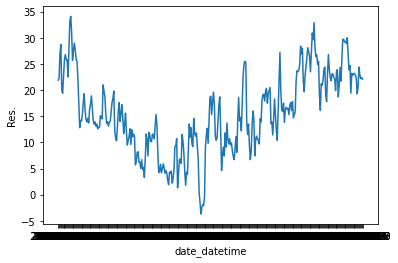

In [25]:
# checking if the temperature values make sens after the merge
merged_grouped =merged_data.groupby(by='date_datetime')['Res.'].max()
sns.lineplot(data=merged_grouped)

<AxesSubplot:xlabel='date_datetime', ylabel='covid_last7'>

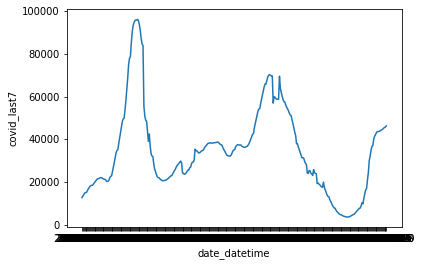

In [26]:
sns.lineplot(data=merged_data.groupby(by='date_datetime')['covid_last7'].mean())

In [27]:
feature = merged_data.drop(columns=['bike_count', 'log_bike_count', 'date_datetime'])
target = merged_data['log_bike_count']

In [28]:
feature.columns

Index(['counter_id', 'site_id', 'latitude', 'longitude', 'hour', 'weekday',
       'dom', 'week', 'month', 'year', 'is_down', 'Res.', 'Vit.', 'Raf.3',
       'Hum. [%]', 'Visi. [Km]', 'pluie_direct', 'pluie_last_3',
       'pluie_intermittente', 'pluie_continue', 'pluie_forte', 'pluie_faible',
       'pluie_modérée', 'neige', 'bruine', 'brouillard', 'verglas',
       'is_daylight', 'temps_soleil', 'pluie_cumul_day', 'vent_max', 'cl',
       'cm', 'ch', 'raf10', 'rafper', 'ht_neige', 'rr1', 'rr3', 'rr6', 'rr12',
       'rr24', 'is_ferie', 'is_holiday', 'covid_last7', 'nb_trot',
       'is_confinement_1', 'commerce_fermes_20', 'couvre_feu_20',
       'couvre_feu_18', 'is_confinement_2', 'is_confinement_3',
       'couvre_feu_21', 'couvre_feu_23'],
      dtype='object')

In [29]:
categorical_columns = ['counter_id', 'site_id', 'is_ferie', 'is_holiday', 'is_confinement_1', 'is_confinement_2', 'commerce_fermes_20', 'couvre_feu_20', 'couvre_feu_18', 'is_confinement_3', 'couvre_feu_21', 'couvre_feu_23', 'weekday', 'year', 'is_daylight', 'cl', 'cm', 'ch', 'pluie_intermittente', 'pluie_continue', 'pluie_forte', 'pluie_faible', 'pluie_modérée', 'neige', 'bruine', 'brouillard', 'verglas', 'is_down']
numerical_columns = [col for col in feature.columns if col not in categorical_columns]

In [30]:
numerical_columns

['latitude',
 'longitude',
 'hour',
 'dom',
 'week',
 'month',
 'Res.',
 'Vit.',
 'Raf.3',
 'Hum. [%]',
 'Visi. [Km]',
 'pluie_direct',
 'pluie_last_3',
 'temps_soleil',
 'pluie_cumul_day',
 'vent_max',
 'raf10',
 'rafper',
 'ht_neige',
 'rr1',
 'rr3',
 'rr6',
 'rr12',
 'rr24',
 'covid_last7',
 'nb_trot']

In [31]:
categories = []
for col in categorical_columns :
    cats = feature[col].unique()
    if np.issubdtype(type(cats[0]), np.number):
        cats.sort()
    categories.append(cats)

categories

[['100056332-104056332', '100047547-104047547', '100047547-103047547', '100057380-103057380', '100047548-103047548', ..., '100056336-106056336', '100056226-104056226', '100056226-103056226', '300014702-353245971', '300014702-353245972']
 Length: 56
 Categories (56, object): ['100007049-101007049', '100007049-102007049', '100036718-103036718', '100036718-104036718', ..., '100063175-353277233', '100063175-353277235', '300014702-353245971', '300014702-353245972'],
 array([100007049, 100036718, 100036719, 100042374, 100044493, 100047542,
        100047545, 100047546, 100047547, 100047548, 100049407, 100050876,
        100056046, 100056047, 100056223, 100056226, 100056327, 100056329,
        100056330, 100056331, 100056332, 100056334, 100056335, 100056336,
        100057329, 100057380, 100057445, 100060178, 100063175, 300014702],
       dtype=int64),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True])

In [36]:
features_train, features_test, target_train, target_test = train_test_split(feature, target, shuffle=False, train_size=0.8)

In [37]:
preprocessor_test = ColumnTransformer([('StandardScaler', StandardScaler(), numerical_columns), ('OrdinalEncoder', OrdinalEncoder(), ['counter_id', 'site_id', 'year'])], remainder='passthrough')

In [38]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(max_depth=30, min_samples_leaf=50, l2_regularization=20, max_iter=1000, categorical_features=list(range(27, 54)))

pipe_hg = make_pipeline(preprocessor_test, model)

In [39]:
pipe_hg.fit(features_train, target_train)

preds = pipe_hg.predict(features_test)

print(mean_squared_error(target_test, preds, squared=False))

0.5633808655924091


In [31]:
preprocessor_deep = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories=categories, drop='first', sparse=False, handle_unknown='ignore'), categorical_columns),
                                ('standard_scaler', StandardScaler(), numerical_columns)])

In [32]:
preprocessor_deep.fit_transform(feature).shape

(455163, 165)

In [34]:
inputs = keras.Input(shape=(165, ))
dense = layers.Dense(256, activation='relu')
x = dense(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

In [35]:
model = keras.Model(inputs=inputs, outputs=outputs, name='bikes_deep')
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "bikes_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 165)]             0         
                                                                 
 dense (Dense)               (None, 256)               42496     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,713
Trainable params: 83,713
Non-trainable params: 0
_________________________________________________________________


In [37]:
pipe = make_pipeline(preprocessor_deep, model)

In [38]:
pipe.fit(features_train, target_train, functional__validation_split=0.2, functional__epochs=20, functional__batch_size=1000, functional__shuffle=False)

Epoch 1/20
292/292 [==============================] - 1s 3ms/step - loss: 2.0508 - val_loss: 1.1024
Epoch 2/20
292/292 [==============================] - 1s 3ms/step - loss: 1.1010 - val_loss: 0.8804
Epoch 3/20
292/292 [==============================] - 1s 3ms/step - loss: 0.7512 - val_loss: 1.0513
Epoch 4/20
292/292 [==============================] - 1s 3ms/step - loss: 0.6144 - val_loss: 0.7832
Epoch 5/20
292/292 [==============================] - 1s 3ms/step - loss: 0.6136 - val_loss: 0.6416
Epoch 6/20
292/292 [==============================] - 1s 3ms/step - loss: 0.6080 - val_loss: 0.6672
Epoch 7/20
292/292 [==============================] - 1s 3ms/step - loss: 0.4938 - val_loss: 0.9371
Epoch 8/20
292/292 [==============================] - 1s 3ms/step - loss: 0.4429 - val_loss: 1.0970
Epoch 9/20
292/292 [==============================] - 1s 3ms/step - loss: 0.4059 - val_loss: 0.9358
Epoch 10/20
292/292 [==============================] - 1s 3ms/step - loss: 0.3960 - val_loss: 0.8205

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(categories=[['100056332-104056332', '100047547-104047547', '100047547-103047547', '100057380-103057380', '100047548-103047548', ..., '100056336-106056336', '100056226-104056226', '100056226-103056226', '300014702-353245971', '300014702-353245972']
Length: 56
Ca...
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'hour', 'dom', 'week',
                                                   'month', 'is_down', 'Res.',
                                                   'Vit.', 'Raf.3', 'Hum. [%]',
                                                   'Visi. [Km]', 'pluie_direct',
                                     

In [39]:
preds = pipe.predict(features_test)
score = mean_squared_error(target_test, preds, squared=False)
print(score)

1.0537142753745465


In [40]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

def build_model():
    inputs = keras.Input(shape=(165, ))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='bikes_deep')
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [41]:
model = KerasRegressor(build_model, validation_split=0.2, epochs=10, batch_size=1000, shuffle=False)

C:\Users\natha\AppData\Local\Temp/ipykernel_8808/3901342833.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_model, validation_split=0.2, epochs=10, batch_size=1000, shuffle=False)


In [42]:
pipe_deep = make_pipeline(preprocessor_deep, model)
pipe_deep.fit(features_train, target_train)

Epoch 1/10
292/292 [==============================] - 2s 5ms/step - loss: 2.3013 - val_loss: 1.3441
Epoch 2/10
292/292 [==============================] - 1s 4ms/step - loss: 1.2701 - val_loss: 0.9116
Epoch 3/10
292/292 [==============================] - 1s 5ms/step - loss: 0.9300 - val_loss: 1.0983
Epoch 4/10
292/292 [==============================] - 1s 4ms/step - loss: 0.7341 - val_loss: 0.9079
Epoch 5/10
292/292 [==============================] - 1s 4ms/step - loss: 0.6304 - val_loss: 0.9805
Epoch 6/10
292/292 [==============================] - 1s 4ms/step - loss: 0.6014 - val_loss: 0.8073
Epoch 7/10
292/292 [==============================] - 1s 4ms/step - loss: 0.5953 - val_loss: 0.7252
Epoch 8/10
292/292 [==============================] - 1s 5ms/step - loss: 0.5276 - val_loss: 1.2659
Epoch 9/10
292/292 [==============================] - 1s 5ms/step - loss: 0.5135 - val_loss: 1.5480
Epoch 10/10
292/292 [==============================] - 1s 4ms/step - loss: 0.4844 - val_loss: 1.0798

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(categories=[['100056332-104056332', '100047547-104047547', '100047547-103047547', '100057380-103057380', '100047548-103047548', ..., '100056336-106056336', '100056226-104056226', '100056226-103056226', '300014702-353245971', '300014702-353245972']
Length: 56
Ca...
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'hour', 'dom', 'week',
                                                   'month', 'is_down', 'Res.',
                                                   'Vit.', 'Raf.3', 'Hum. [%]',
                                                   'Visi. [Km]', 'pluie_direct',
                                                   'pluie_last_3',
                                       

In [43]:
preds = pipe_deep.predict(features_test)
mean_squared_error(preds, target_test, squared=False)

1.12838017293353

In [37]:
from sklearn.linear_model import Ridge

tss = TimeSeriesSplit()
cv = tss.split(features_train)

preprocessor = ColumnTransformer([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_columns),
                                    ('standard_scaler', StandardScaler(), numerical_columns)])

pipe_ridge = make_pipeline(preprocessor, Ridge(alpha=6))

pipe_ridge.fit(features_train, target_train)

preds = pipe_ridge.predict(features_test)

print(mean_squared_error(target_test, preds, squared=False))

0.9267377433949091


In [45]:
from sklearn.ensemble import RandomForestRegressor

pipe_forest = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, max_samples=50000, max_depth=10, min_samples_leaf=10))
pipe_forest.fit(features_train, target_train)

preds = pipe_forest.predict(features_test)

print(mean_squared_error(preds, target_test, squared=False))

0.8577677587977174


In [46]:
from sklearn.ensemble import HistGradientBoostingRegressor

tss = TimeSeriesSplit()
cv = tss.split(features_train)

regressor = HistGradientBoostingRegressor(max_depth=30, min_samples_leaf=50, l2_regularization=20, max_iter=1000)

pipe_hist = make_pipeline(preprocessor, regressor)

pipe_hist.fit(features_train, target_train)

preds = pipe_hist.predict(features_test)

print(mean_squared_error(target_test, preds, squared=False))

0.6274416800649372


In [120]:
pipe_hist.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'histgradientboostingregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__one_hot_encoder', 'columntransformer__standard_scaler', 'columntransformer__one_hot_encoder__categories', 'columntransformer__one_hot_encoder__drop', 'columntransformer__one_hot_encoder__dtype', 'columntransformer__one_hot_encoder__handle_unknown', 'columntransformer__one_hot_encoder__sparse', 'columntransformer__standard_scaler__copy', 'columntransformer__standard_scaler__with_mean', 'columntransformer__standard_scaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learni

In [35]:
features_train_cv, features_test_cv, target_train_cv, target_test_cv = train_test_split(features_test, target_test, shuffle=False)

In [39]:
from xgboost import XGBRegressor

tss = TimeSeriesSplit()
cv = tss.split(features_train_cv)

pipe_xgb = make_pipeline(preprocessor, XGBRegressor())

params = {'xgbregressor__min_samples_leaf' : [50, 100, 200],
            'xgbregressor__max_depth' : [10, 30, 50],
            'xgbregressor__gamma' : [0.2, 1, 2]}

rcv = RandomizedSearchCV(pipe_xgb, param_distributions=params, scoring='neg_root_mean_squared_error', cv=cv, n_iter=3)

# pipe_xgb.fit(features_train, target_train)

rcv.fit(features_train_cv, target_train_cv)

print(rcv.best_params_)
print(-rcv.score(features_test_cv, target_test_cv))

# preds = pipe_xgb.predict(features_test)

# print(mean_squared_error(target_test, preds, squared=False))

[15:18:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_samples_leaf" } might not be 

In [48]:
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__one_hot_encoder', 'columntransformer__standard_scaler', 'columntransformer__one_hot_encoder__categories', 'columntransformer__one_hot_encoder__drop', 'columntransformer__one_hot_encoder__dtype', 'columntransformer__one_hot_encoder__handle_unknown', 'columntransformer__one_hot_encoder__sparse', 'columntransformer__standard_scaler__copy', 'columntransformer__standard_scaler__with_mean', 'columntransformer__standard_scaler__with_std', 'xgbregressor__objective', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__enable_catego

In [49]:
XGBRegressor?

Init signature:
XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : typing.Union[str, typing.Callable[[numpy.ndarray, numpy.ndarray], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: Optional[str]
        